Marklin Example: Compute vacuum field in a 3D boundary (NCSX) {#doc_marklin_ncsx_ex}
==========
In this example we compute the the vacuum magnetic field with a specified flux within a complex 3D toroidal region, the LCFS of NCSX in this case. We then demonstrate tracing the resulting field as well as compute the result of heating with anisotropic thermal conduction aligne to the magnetic field.

In [1]:
import os
import sys
import time
import h5py
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load Marklin library

To load the Marklin python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.Marklin import Marklin

## Compute vacuum field

### Initialize Marklin object
First we create a Marklin instance to use for field calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
myOFT = OFT_env(nthreads=4)
taylor_solver = Marklin(myOFT)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   Marklin_vacuum
Revision id:          642ca7e
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    4
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_8468/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh
Now we load a mesh of the desired region generated using [Cubit](https://cubit.sandia.gov/) using \ref OpenFUSIONToolkit.Marklin.Marklin.setup_mesh "setup_mesh()".

In [4]:
taylor_solver.setup_mesh(mesh_file='NCSX_plasma.h5',grid_order=2)
taylor_solver.setup(order=2,minlev=1)


**** Loading OFT mesh
  Mesh File = NCSX_plasma.h5

**** Generating grid level  1
  Generating domain linkage
  Generating boundary domain linkage
  Mesh statistics:
    Volume          =  2.971E+00
    Surface area    =  2.445E+01
    # of points     =   39405
    # of edges      =  251752
    # of faces      =  413201
    # of cells      =  200854
    # of boundary points =   11493
    # of boundary edges  =   34479
    # of boundary faces  =   22986
    # of boundary cells  =   22873
  Resolution statistics:
    hmin =  2.709E-02
    hrms =  5.283E-02
    hmax =  1.318E-01
  Surface grounded at vertex   16292




**** Creating Lagrange FE space
  Order  =    2
  Minlev =    1


**** Creating H(Curl) FE space
  Order  =    2
  Minlev =    1



### Compute vacuum field
In marklin vacuum field within a multiply connected volume, like a torus, can be computed by specifying the flux thrugh a given cut plane that traverses the mesh. In the case of a topological torus, like NCSX, this cut plane should be a poloidal plane, which we specify using a center point `hcpc` and unit normal direction `hcpv`. This defines a circular cut surface, where the amplitude of `hcpv` set the radius $r = 1/|hcpv|$, that is used to slice the model.

We then use \ref OpenFUSIONToolkit.Marklin.Marklin.compute_vac "compute_vac()" to compute the vacuum field with unit flux through the specified plane.

**Note:** In general multiple slice planes are allowed for more complex geometry (see [Benedett et al. 2021](https://doi.org/10.1088/1741-4326/abd41c)).

In [5]:
nh = 1
hcpc = np.array([[1.5,0.0,0.0],])
hcpv = np.array([[0.0,0.4,0.0],])
taylor_solver.compute_vac(nh,hcpc,hcpv)


**** Creating H^1 FE space
  Order  =    3
  Minlev =    1


**** Creating H(Curl) + Grad(H^1) FE space
  Order  =    2
  Minlev =    1



Starting CG solver
     0  0.000000E+00  0.000000E+00  5.196134E-01
     1 -1.241239E+00  7.558267E+00  1.678812E-01  2.221160E-02
     2 -1.592051E+00  1.287183E+01  8.550400E-02  6.642725E-03
     3 -1.738624E+00  1.825675E+01  5.840551E-02  3.199119E-03
     4 -1.816082E+00  1.892195E+01  5.035339E-02  2.661110E-03
     5 -1.866464E+00  1.893167E+01  4.097687E-02  2.164461E-03
     6 -1.904393E+00  1.918058E+01  3.258061E-02  1.698625E-03
     7 -1.932401E+00  1.967075E+01  2.846816E-02  1.447233E-03
     8 -1.952755E+00  2.026996E+01  2.453982E-02  1.210650E-03
     9 -1.969077E+00  2.101250E+01  2.169898E-02  1.032670E-03
    10 -1.981978E+00  2.186385E+01  1.964990E-02  8.987395E-04
    20 -2.042309E+00  2.925770E+01  9.192464E-03  3.141896E-04
    30 -2.063302E+00  3.548574E+01  6.431481E-03  1.812413E-04
    40 -2.074084E+00  4.090133E+01  4.648587E-03  1.136537E-04
    50 -2.080637E+00  4.577368E+01  3.819397E-03  8.344090E-05
    60 -2.085032E+00  5.019740E+01  3.099724E-03  

## Trace magnetic field

### Get field evaluation object
To trace the magnetic field in python we need to retrieve an interpolation object to enable evaluation of the field at arbitrary points. This can be done using \ref OpenFUSIONToolkit.Marklin.Marklin.get_binterp "get_binterp()", where the flux is set by the `vac_facs` argument.

In [6]:
binterp_obj = taylor_solver.get_binterp(vac_facs=np.r_[1.0,])

### Define tracer function for ODE integration

In [7]:
def tracer_eval(y, t, interp_obj, fac):
    b = interp_obj.eval(y)
    if interp_obj.cell.value <= 0:
        return [0.0,0.0,0.0]
    else:
        return b*fac

### Perform field line tracing
Now we trace a single field line for `[1.5, 0.0, 0.0]`, where we trace forward and backward along the field line by applying a scale factor of `-1.0` in the second case.

In [8]:
t = np.linspace(0, 40, 1000)
t0 = time.perf_counter()
sol, infodict = odeint(tracer_eval, np.array([1.5,0.0,0.0]), t, args=(binterp_obj,1.0), atol=1.E-9, full_output=True)
sol2, infodict2 = odeint(tracer_eval, np.array([1.5,0.0,0.0]), t, args=(binterp_obj,-1.0), atol=1.E-9, full_output=True)
t1 = time.perf_counter()
print("Time = {0:.3F} [s]".format(t1-t0))
print("Time/step = {0:.2E} [s]".format((t1-t0)/(np.sum(infodict['nfe'])+np.sum(infodict2['nfe']))))

Time = 1.287 [s]
Time/step = 1.18E-08 [s]


### Plot resulting field lines

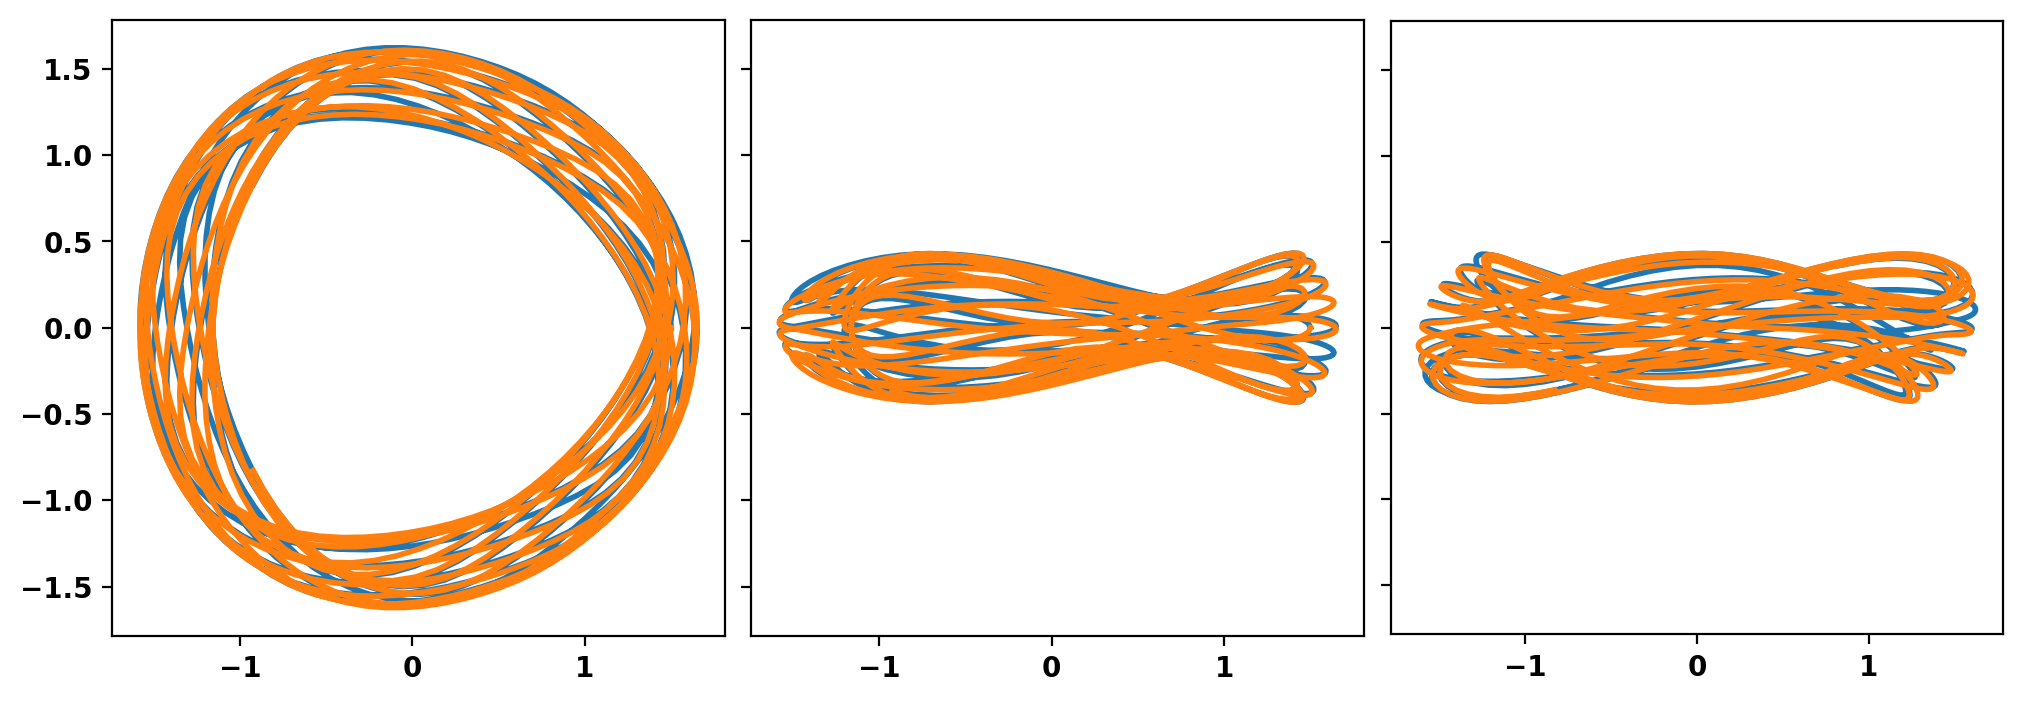

In [9]:
fig, ax = plt.subplots(1,3,sharey=True,figsize=(10,4),constrained_layout=True)
ax[0].plot(sol[:,0],sol[:,1])
ax[0].plot(sol2[:,0],sol2[:,1])
ax[0].set_aspect('equal','box')
ax[1].plot(sol[:,0],sol[:,2])
ax[1].plot(sol2[:,0],sol2[:,2])
ax[1].set_aspect('equal','box')
ax[2].plot(sol[:,1],sol[:,2])
ax[2].plot(sol2[:,1],sol2[:,2])
ax[2].set_aspect('equal','box')

### Save field for 3D plotting

In [10]:
taylor_solver.setup_io()
taylor_solver.save_field(binterp_obj,'B')

Starting CG solver
     0  0.000000E+00  0.000000E+00  2.512636E-02
     1 -1.284860E+01  1.074343E+03  2.478268E-03  2.306775E-06
     2 -1.432609E+01  1.666399E+03  6.082516E-04  3.650095E-07
     3 -1.433662E+01  1.673020E+03  1.065931E-04  6.371296E-08
     4 -1.433710E+01  1.672989E+03  4.698798E-05  2.808624E-08
     5 -1.433722E+01  1.672883E+03  2.567654E-05  1.534867E-08
     6 -1.433726E+01  1.672797E+03  1.396381E-05  8.347583E-09
     7 -1.433727E+01  1.672778E+03  7.588359E-06  4.536382E-09
     8 -1.433727E+01  1.672777E+03  4.353274E-06  2.602424E-09
     9 -1.433727E+01  1.672780E+03  2.485503E-06  1.485852E-09
    10 -1.433727E+01  1.672783E+03  1.297498E-06  7.756521E-10
    20 -1.433727E+01  1.672790E+03  6.489980E-09  3.879734E-12


## Solver parallel diffusion
We now compute a parallel diffusion problem to get the temperature produced in response to uniform heating with anisotropic transport that is slow in the cross-field direction compared to the parallel direction. In this case we use $\chi_{\parallel}/\chi_{\perp} = 10^5$. 

In [11]:
t0 = time.perf_counter()
taylor_solver.compute_par_diff(binterp_obj,1.E-5)
t1 = time.perf_counter()
print('Solver time = {0:.4} [s]'.format(t1-t0))

Starting CG solver
     0  0.000000E+00  0.000000E+00  8.084242E-03
     1 -9.285216E-04  2.399326E-01  1.170790E-02  4.879660E-02
     2 -5.389076E-03  1.618621E+00  2.491258E-02  1.539123E-02
     3 -1.544873E-02  4.861987E+00  3.221482E-02  6.625855E-03
     4 -2.779872E-02  8.907011E+00  3.337504E-02  3.747053E-03
     5 -4.616194E-02  1.499180E+01  4.605103E-02  3.071747E-03
     6 -7.104545E-02  2.332810E+01  4.857101E-02  2.082082E-03
     7 -9.931607E-02  3.287841E+01  5.062435E-02  1.539744E-03
     8 -1.359469E-01  4.533555E+01  6.371587E-02  1.405428E-03
     9 -1.796943E-01  6.028997E+01  6.245061E-02  1.035837E-03
    10 -2.321670E-01  7.829372E+01  7.044421E-02  8.997428E-04
    20 -1.230217E+00  4.257862E+02  1.060530E-01  2.490757E-04
    30 -3.193057E+00  1.118217E+03  1.443705E-01  1.291078E-04
    40 -6.078533E+00  2.144452E+03  1.713346E-01  7.989668E-05
    50 -9.759393E+00  3.461204E+03  1.884273E-01  5.443983E-05
    60 -1.396066E+01  4.971270E+03  1.862839E-01  

## Plot temperature on clipped volume using pyvista
Finally we plot the temperature on a clipped volume showing nested temperature contours from the wall to the core using [pyvista](https://pyvista.org/).

### Load data from plot files
To plot the fields we must load in the mesh from the plot files.

**Note:** In the future this will be handled by dedicated python functions, but we show it here at the moment for demonstration purposes.

Removing old Xdmf files
  Removed 2 files

Creating output files: oft_xdmf.XXXX.h5
  Found Group: marklin
    Found Mesh: smesh
      # of blocks: 1
    Found Mesh: vmesh
      # of blocks: 1


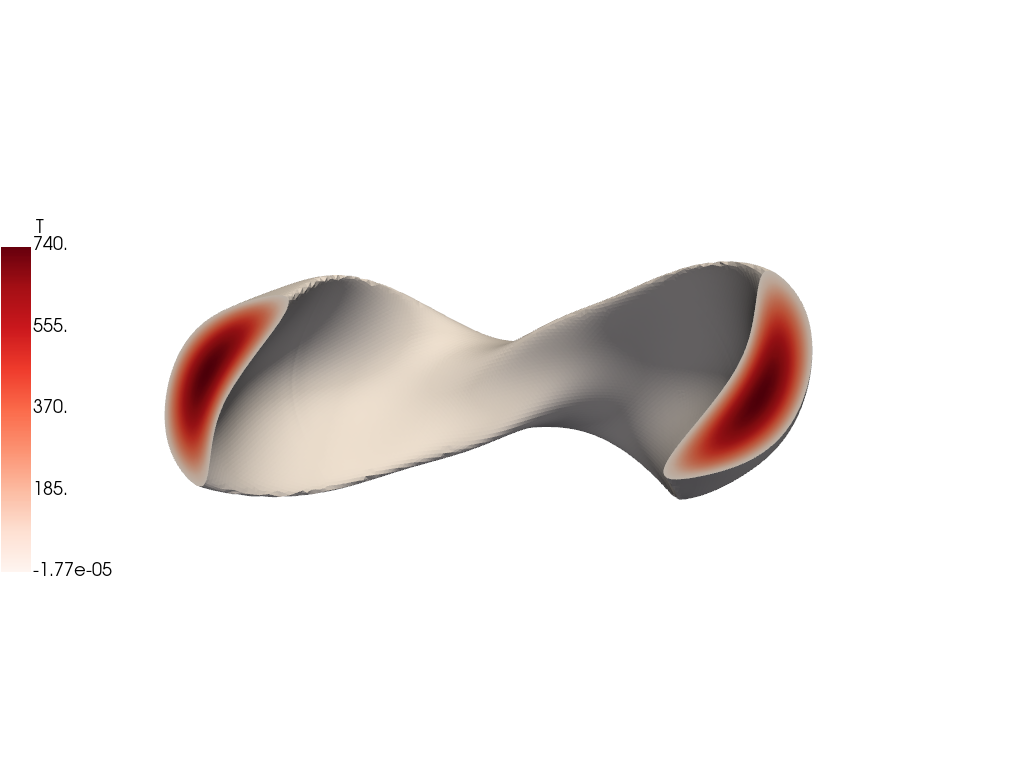

In [12]:
import pyvista
plot_data = taylor_solver.build_XDMF()
grid = plot_data['marklin']['vmesh'].get_pyvista_grid()
T = plot_data['marklin']['vmesh'].get_field('T')

grid["scalars"] = T
slice_x = grid.clip(normal='x')
p = pyvista.Plotter()
p.add_mesh(slice_x, cmap="Reds", scalar_bar_args={'title': "T", "vertical": True, "position_y":0.25, "position_x": 0.0})
p.camera.position = (7.0,2.0,0.0)
p.show(jupyter_backend='static')